In [28]:
from classiq import *
import numpy as np
import math

In [30]:
x0 = np.array([1, 1])
M = np.array([[0, 1], [-1, 0]])

# Free to change variables
t = 0.1
K = 7 # Accuracy of solution - k+1 must be a multiple of 2
T = math.ceil(math.log2(K+1))

In [41]:
def C(m):
   return 2 ** ((m + 1) / 2) * t ** m / math.factorial(m)

N = math.sqrt(sum([C(i) for i in range(K+1)])) # This also equals to $\mathcal{C}$ in the paper

In [21]:
def proj(v1, v2):
    """Calculates the projection of v1 onto v2"""
    return np.dot(v1, v2) / np.dot(v2, v2) * np.array(v2)

def generate_encode_unitaries():
    """
    Performs Gram Schmidt procedure to create VS1 and WS1
    
    NOTE: The way it is currently implemented K+1 must be a multiple of 2 to
        guarantee obtaining a unitary matrix
    """
    state = []

    for i in range(2 ** T):
        if len(state) < K + 1:
            state.append(math.sqrt(C(i)) / N)

        else:
            state.append(0)

    WS1 = [state]
    
    for i in range(2 ** T):
        basis_v = [0 for _ in range(2 ** T)]
        basis_v[i] = 1
        s = np.array(basis_v[:])
    
        for v in WS1:
            s = s - proj(s, v)
    
        if np.linalg.norm(s) != 0:
            s = s / np.linalg.norm(s)
            WS1.append(s.tolist())
        
    WS1 = WS1[:2 ** T]
    VS1 = np.transpose(WS1).tolist()

    return (VS1, WS1)

In [22]:
# TODO Initialize ancilla registers with the correct quantum states
# NOTE Our b vector is zero, therefore C-V_S2 and C-U_b do not need to be implemented, but could be for future purposes


print("Register sizes:", 1, T, 1)
VS1, WS1 = generate_encode_unitaries()

@qfunc
def main(ancilla_reg: Output[QNum], work_reg: Output[QBit]):
   allocate(T, ancilla_reg)
   allocate(1, work_reg)

   # Encode stage
   unitary(VS1, ancilla_reg)
   H(work_reg)

   # Generate entanglement
   repeat(
      count=K + 1,
      iteration=lambda i: if_(
         condition=(i % 2 != 0),
         then=lambda: control(
               ctrl=(ancilla_reg == i), stmt_block=lambda: Y(work_reg)
            ),
         ),
      )
   
   # Decode stage
   unitary(WS1, ancilla_reg)

Register sizes: 1 3 1


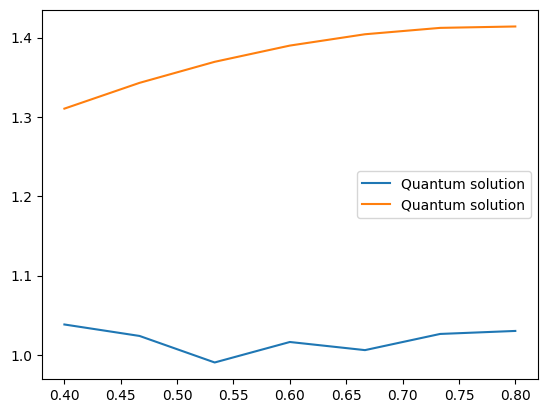

In [40]:
import matplotlib.pyplot as plt

t_vals = np.linspace(0.4, 0.8, 7)
y_vals = []
for t in t_vals:
   qmod = create_model(main)
   qprog = synthesize(qmod)
   job = execute(qprog)
   results = job.result()[0].value.parsed_counts

   for r in results:
      if r.state['ancilla_reg'] == 0 and r.state['work_reg'] == 1:
         y_vals.append(math.sqrt(r.shots / 2048) * N ** 2)

plt.plot(t_vals, y_vals, label="Quantum solution")
plt.plot(t_vals, np.sin(t_vals) + np.cos(t_vals), label="Quantum solution")
plt.legend()
plt.show()

In [42]:
t

0.8

In [44]:
write_qmod(create_model(main), "t=0.8-k=7")